In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import json
from itertools import chain, product, permutations
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, BRICS
from krxns.cheminfo import expand_unpaired_cofactors, mcs, draw_molecule, draw_reaction
from krxns.config import filepaths
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import entropy
from IPython.display import display, SVG
from tqdm import tqdm
print(rdkit.__version__)

2024.03.2


In [2]:
# Load known reaction data
with open(filepaths['data'] / "sprhea_240310_v3_mapped.json", 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Extract known compounds
known_compounds = {}
for elt in known_reactions.values():
    subs = chain(*[side.split(".") for side in elt['smarts'].split(">>")])
    for sub in subs:
        known_compounds[sub] = elt['smi2name'].get(sub, None)

known_compounds = {i: {'smiles': k, 'name': v} for i, (k, v) in enumerate(known_compounds.items())}
smi2id = {v['smiles']: k for k, v in known_compounds.items()}

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]

known_reactions = {k: known_reactions[k] for k in keepers}
print(len(known_reactions))

9801


In [4]:
# Load cofactors

k = 10

paired_fp = filepaths['cofactors'] / "paired_cofactors_reference.tsv"
unpaired_fp = filepaths['cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
    'CoA'
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]

cofactors = expand_unpaired_cofactors(filtered_unpaired, k=k)

manual = {
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide',
    '[Cl-]': 'chloride',
    '[Na+]': 'sodium'
}

cofactors = {**cofactors, ** manual}
cofactors

[15:03:41] WARNING: not removing hydrogen atom without neighbors


{'C#[O+]': nan,
 'O=C=O': 'CO2',
 'O=C(O)O': 'hydrogencarbonate',
 '[H+]': nan,
 'OO': 'H2O2',
 'Br': nan,
 'C#N': 'hydrogen cyanide',
 '[C-]#[NH+]': 'hydrogen cyanide',
 'Cl': nan,
 'F': nan,
 'I': nan,
 'N': 'NH4(+)',
 'O=O': 'O2',
 'O=P(O)(O)OP(=O)(O)O': 'diphosphate',
 'O=P(O)(O)O': 'phosphate',
 'O=S(=O)(O)O': 'sulfate',
 'O=S(O)O': 'sulfite',
 'O': 'H2O',
 'N#N': 'N2',
 '[H][H]': 'H2',
 'S': 'hydrogen sufide',
 '[Cl-]': 'chloride',
 '[Na+]': 'sodium'}

In [4]:
print([elt for elt in cofactors.values() if type(elt) is str])

['CO2', 'hydrogencarbonate', 'H2O2', 'hydrogen cyanide', 'hydrogen cyanide', 'NH4(+)', 'O2', 'diphosphate', 'phosphate', 'sulfate', 'sulfite', 'H2O', 'N2', 'H2', 'hydrogen sufide', 'chloride', 'sodium']


In [5]:
# Create naive graph

G = nx.Graph()

G.add_nodes_from([(k, v) for k,v in known_compounds.items()])

for rid, rxn in known_reactions.items():
    lhs, rhs = [side.split(".") for side in rxn['smarts'].split(">>")]
    for pair in product(lhs, rhs):
        left_cid, right_cid = smi2id[pair[0]], smi2id[pair[1]]
        G.add_edge(left_cid, right_cid, **rxn)

print(G.number_of_nodes(), G.number_of_edges())

8777 28339


Demonstrate the problem with naively connecting all substrates that appear opposite one another in a reaction

In [6]:
nad_ids = {}
for id in known_compounds:
    name = known_compounds[id]['name']
    if name:
        if 'NAD' in name:
            nad_ids[name] = id
nad_ids

{'NADP(+)': 1,
 'NADPH': 4,
 'NADH': 47,
 'NAD(+)': 50,
 '(6S)-NADHX;(6R)-NADHX': 196,
 'deamido-NAD(+)': 210,
 "a 5'-end NAD(+)-phospho-ribonucleoside residue": 1276,
 '(6S)-NADPHX;(6R)-NADPHX': 1689,
 '1,2-dihydro-beta-NADP': 4071,
 '1,6-dihydro-beta-NAD': 4991,
 '1,2-dihydro-beta-NAD': 5010,
 '1,6-dihydro-beta-NADP': 7162}

In [7]:
print(G.nodes[47]['name'])
[(idx, G.nodes[idx]['name'], G.nodes[idx]['smiles']) for idx in G.neighbors(47)]

NADH


[(3565, '2,5-dihydroxybenzoate', 'O=C(O)c1cc(O)ccc1O'),
 (50,
  'NAD(+)',
  'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'),
 (7, 'H2O', 'O'),
 (613, 'a 1,4-benzosemiquinone', '*c1c(*)c(O)c(*)c(*)c1[O]'),
 (2271, '(2R)-3-sulfolactate', 'O=C(O)C(O)CS(=O)(=O)O'),
 (2003, 'corticosterone', 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C(C(=O)CO)CCC12'),
 (5707, 'spermine monoaldehyde', 'NCCCNCCCCNCCC=O'),
 (2197, 'phylloquinol', 'CC(=CCc1c(C)c(O)c2ccccc2c1O)CCCC(C)CCCC(C)CCCC(C)C'),
 (3951,
  '7alpha,25-dihydroxycholesterol',
  'CC(CCCC(C)(C)O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C'),
 (1901, 'squalene', 'CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC=C(C)C'),
 (37, 'diphosphate', 'O=P(O)(O)OP(=O)(O)O'),
 (2280,
  'lithocholoyl-CoA',
  'CC(CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C'),
 (596, 'shikimate', 'O=C(O)C1=CC(O)C(O)C(O)C1'),
 (3114,
  'cis-4,5-dihydroxycyclohexa-2,6-diene-1,2-dic

In [8]:
corticosterone_nad = G.edges[47, 2003]
formate_nad = G.edges[47, 13]

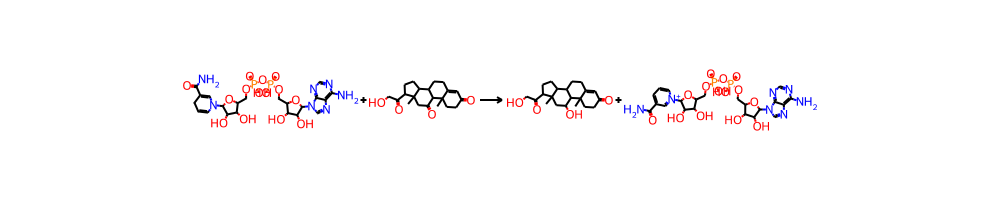

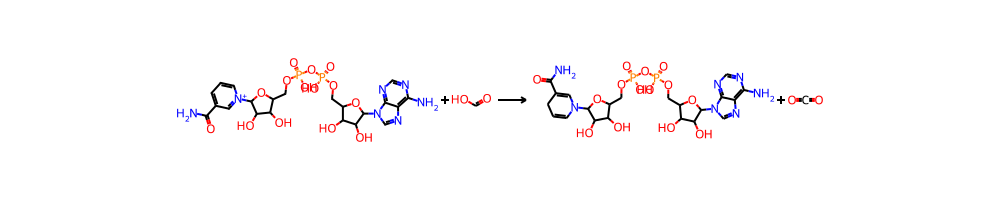

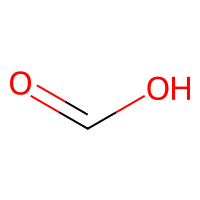

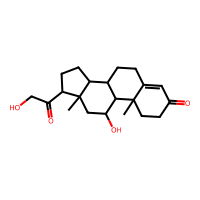

In [9]:
display(SVG(draw_reaction(corticosterone_nad['smarts'])))
display(SVG(draw_reaction(formate_nad['smarts'])))
formate = [v for v in known_compounds.values() if v['name'] == 'formate'][0]
display(SVG(draw_molecule(formate['smiles'])))
corticosterone = [v for v in known_compounds.values() if v['name'] == 'corticosterone'][0]
SVG(draw_molecule(corticosterone['smiles']))

Align reactants & products on a reaction-by-reaction basis

In [10]:
def filter_cofactors(known_reactions: dict[str, dict], cofactors: dict[str, str], paired_cofactors: dict[tuple, float] = {}):
    '''
    Filters cofactors out of known reaction dict
    '''
    paired_cofactors = {tuple(sorted(k)): v for k, v in paired_cofactors.items()}

    filtered_krs = {}
    for rid, rxn in known_reactions.items():
        lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
        lhs = sorted([elt for elt in lhs if elt not in cofactors])
        rhs = sorted([elt for elt in rhs if elt not in cofactors])

        if not lhs or not rhs:
            continue

        to_remove = tuple()
        best_jaccard = 0
        for pair in product(lhs, rhs):
            srt_pair = tuple(sorted(pair))

            if srt_pair in paired_cofactors and paired_cofactors[srt_pair] > best_jaccard:
                to_remove = pair # Note NOT srt pair
                best_jaccard = paired_cofactors[srt_pair]

        if to_remove:
            lhs.remove(to_remove[0])
            rhs.remove(to_remove[1])

        if len(lhs) > len(rhs):
            tmp = lhs
            lhs = rhs
            rhs = tmp

        filtered_krs[rid] = (lhs, rhs)
    
    return filtered_krs

def plot_side_counts(side_counts: dict[tuple, set]):
    x_labels, cts = zip(*sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True))
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots()
    ax.bar(x, height=cts)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_ylabel("# reactions")
    ax.set_xlabel("(# reactants, # products)")
    plt.show()

    return fig

def connect_reaction(rsms: dict[str, pd.DataFrame], paired_cofactors: dict[tuple[int], float] = {}):
    '''
    Args
    ----
    rsms: dict[str, pd.DataFrame]
        Metric name : (n_rcts x n_pdts) reaction similarity matrix
    '''
    def get_partner(sim:np.ndarray, candidates:list):
        '''
        Selects partner for a substrate (reactant 
        for a product or product for a reactant) using 
        the metric that gives the lowest entropy distribution

        Args
        ----
        sim
            (n_candidates x n_metrics) matrix
        candidates
            List of candidate ids
        '''
        # Filtering out probability-mass-less metrics
        mass = sim.sum(axis=0).reshape(1, -1)
        _, j = np.nonzero(mass)
        sim = sim[:, j] / mass[:, j]
        H = entropy(sim, axis=0).reshape(-1,)
        midx = np.argmin(H)
        return candidates[np.argmax(sim[:, midx])]

    n_metrics = len(rsms)
    
    tmp_lid = set()
    tmp_rid = set()
    for v in rsms.values():
        tmp_lid.add(tuple(v.index))
        tmp_rid.add(tuple(v.columns))

    if len(tmp_lid) > 1 or len(tmp_rid) > 1: # Check that cpd ids consistent across rxn sim mats
        raise ValueError("IDs from similarity matrices are not the same")
    else: # Get lists of left and right side compound ids
        lid = list(list(tmp_lid)[0])
        rid = list(list(tmp_rid)[0])

    # Create adjacency matrix
    adj_mat = pd.DataFrame(
        data=np.zeros(shape=(len(lid), len(rid))),
        index=lid,
        columns=rid
    )

    # Handle paired cofactors (predetermined canonical pairs)
    if paired_cofactors:
        paired_cofactors = {tuple(sorted(k)): v for k, v in paired_cofactors.items()}

        to_remove = tuple()
        best_jaccard = 0
        for pair in product(lid, rid):
            srt_pair = tuple(sorted(pair))

            if srt_pair in paired_cofactors and paired_cofactors[srt_pair] > best_jaccard:
                to_remove = pair # Note NOT srt pair
                best_jaccard = paired_cofactors[srt_pair]

        if to_remove:
            li, rj = to_remove
            adj_mat.loc[li, rj] = 1 # Insert connections into adj_mat

            # Remove from lid, rid before creating sim block
            lid.remove(li)
            rid.remove(rj)

    # End if have run out of either rcts or pdts
    if len(lid) == 0 or len(rid) == 0:
        return {}
    
    # Create sim block w/ remaining non-canonical pairs
    sim_block = []
    for v in rsms.values():
        sim_block.append(v.loc[lid, rid].to_numpy())
    sim_block = np.stack(sim_block, axis=-1) # (n_rcts x n_pdts x n_metrics)
    
    # Select partner for each reactant
    left_partners = {}
    for i, li in enumerate(lid):
        sim = sim_block[i, :, :].copy().reshape(-1, n_metrics)
        left_partners[li] = get_partner(sim, rid)

    # Select partner for each product
    right_partners = {}
    for j, rj in enumerate(rid):
        sim = sim_block[:, j, :].copy().reshape(-1, n_metrics)
        right_partners[rj] = get_partner(sim, lid)

    
    # Fill out adjacency matrix

    for li, p in left_partners.items():
        adj_mat.loc[li, p] = 1

    for rj, p in right_partners.items():
        adj_mat.loc[p, rj] = 1

    return {"left": left_partners, "right": right_partners, "adj_mat": adj_mat}

def is_frustrated(rxn_sim_mat: pd.DataFrame):
    rxn_sim_mat = rxn_sim_mat.to_numpy()

    if rxn_sim_mat.shape[0] > rxn_sim_mat.shape[1]:
        rxn_sim_mat = rxn_sim_mat.T

    m, n = rxn_sim_mat.shape
    rct_partners = np.argmax(rxn_sim_mat, axis=1)
    pdt_partners = np.argmax(rxn_sim_mat, axis=0)
    partner_matches = [pdt_partners[rct_partners[i]] == i for i in range(len(rct_partners))]

    if sum(partner_matches) == m:
        return False
    else:
        return True


In [6]:
cpd_appears_in = defaultdict(set)

# Reaction co-appearance matrix (Jaccard)
cpd_corr = np.zeros(shape=(len(known_compounds), len(known_compounds)))
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])

    for elt in chain(lhs, rhs):
        cpd_appears_in[smi2id[elt]].add(rid)

    for pair in product(lhs, rhs):
        i, j = [smi2id[elt] for elt in pair]
        cpd_corr[i, j] += 1
        cpd_corr[j, i] += 1
    
row_sum = cpd_corr.sum(axis=1).reshape(-1, 1)
col_sum = cpd_corr.sum(axis=0).reshape(1, -1)
cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric

# Structural based sim mats
cpd_tani = np.load(filepaths['sim_mats'] / "tanimoto.npy")
cpd_mcs = np.load(filepaths['sim_mats'] / "mcs.npy")

# BRICS based assigment matrix (not currently used)
brics_mats = {}
brics_filepath = filepaths['sim_mats'] / "brics"
for fn in brics_filepath.iterdir():
    rid = int(fn.stem)
    df = pd.read_csv(fn, sep='\t', index_col=0)
    brics_mats[rid] = df

# Consolidate sim mats
cc_sim_mats = {
    'mcs': cpd_mcs,
    'tanimoto': cpd_tani,
    'jaccard': cpd_jaccard,
}

# Count # rxns that cpds appear in
rxns_per_cpd = {k: len(v) for k, v in cpd_appears_in.items()}

# Re-format Jaccard
id2jaccard = {} # Maps sorted cpd id pair to jaccard score
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])
    for pair in product(lhs, rhs):
        ids = tuple(sorted([smi2id[elt] for elt in pair]))
        id2jaccard[ids] = cpd_jaccard[ids[0], ids[1]]

# Sort Jaccard
srt_cofactor_pairs = sorted(id2jaccard, key=lambda x : id2jaccard[x], reverse=True)
srt_jaccards = [id2jaccard[id] for id in srt_cofactor_pairs]

/tmp/ipykernel_125326/2468684086.py:20: RuntimeWarning: invalid value encountered in divide
  cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
/tmp/ipykernel_125326/2468684086.py:21: RuntimeWarning: invalid value encountered in divide
  cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric


In [13]:
a = np.argwhere((row_sum + col_sum - cpd_corr) == 0)
b = np.argwhere((row_sum + col_sum) == 0)

# cpd_corr / (row_sum + col_sum - cpd_corr)
i, j = np.nonzero((row_sum + col_sum - cpd_corr))
cpd_corr[i]

(array([   0,    0,    0, ..., 8775, 8776, 8776]),
 array([   3,    4,   30, ..., 7949,    4, 5019]))

In [20]:
np.isnan(np.where((row_sum + col_sum - cpd_corr) != 0, cpd_corr / (row_sum + col_sum - cpd_corr), 0)).any()

/tmp/ipykernel_125326/1941342892.py:1: RuntimeWarning: invalid value encountered in divide
  np.isnan(np.where((row_sum + col_sum - cpd_corr) != 0, cpd_corr / (row_sum + col_sum - cpd_corr), 0)).any()


False

In [21]:
np.isnan( cpd_corr / (row_sum + col_sum - cpd_corr)).any()

/tmp/ipykernel_125326/3413051499.py:1: RuntimeWarning: invalid value encountered in divide
  np.isnan( cpd_corr / (row_sum + col_sum - cpd_corr)).any()


True

In [12]:
known_compounds[2]

{'smiles': 'O=P(O)(O)O', 'name': 'phosphate'}

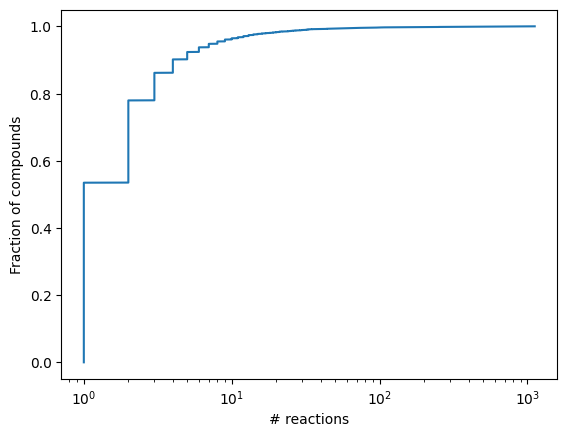

0.8990982764524598 4


In [12]:
# Plot cdf of occurrence of cpds in rxns

ep = 1e-3
thresh = 0.9
srt_cpd_rxn_cts = sorted(rxns_per_cpd.values(), reverse=False)
cdf = np.arange(1, len(srt_cpd_rxn_cts) + 1) / len(srt_cpd_rxn_cts)
idx = np.where(abs(cdf - thresh) < ep)[0][0]
plt.plot(srt_cpd_rxn_cts, cdf)
plt.xscale('log')
plt.xlabel('# reactions')
plt.ylabel('Fraction of compounds')
plt.show()
print(cdf[idx], srt_cpd_rxn_cts[idx])

In [13]:
thresh_n_rxns = 5
k_top_pairs = 30

top_names = [[known_compounds[id]['name'] for id in pair] for pair in srt_cofactor_pairs if all([rxns_per_cpd[id] > thresh_n_rxns for id in pair])][:100]

for i, elt in enumerate(top_names):
    print(i, elt)

0 ['a quinone', 'a quinol']
1 ['FMNH2', 'FMN']
2 ['Fe(3+)', 'Fe(2+)']
3 ['NADH', 'NAD(+)']
4 ['methyl-Co(III)', 'Co(+)']
5 ['FAD', 'FADH2']
6 ['NADP(+)', 'NADPH']
7 ['N(omega),N(omega)-dimethyl-L-arginine', '5-(3,3-dimethylguanidino)-2-oxopentanoate']
8 ["adenosine 3',5'-bisphosphate", "3'-phosphoadenylyl sulfate"]
9 ['Cu(+)', 'Cu(2+)']
10 ['A', 'AH2']
11 ['S-adenosyl-L-methionine', 'S-adenosyl-L-homocysteine']
12 ['L-kynurenine', 'kynurenate']
13 ['coenzyme B', 'coenzyme M-coenzyme B heterodisulfide']
14 ['N(6)-biotinyl-L-lysine residue', 'carboxybiotinyl-L-lysine residue']
15 ['L-histidine residue', 'N(pros)-phospho-L-histidine residue']
16 ['L-ascorbate', 'monodehydro-L-ascorbate radical']
17 ["1'-[1,2-di-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phospho]-3'-[1-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phospho]-glycerol", "1',3'-bis-[1,2-di-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phospho]-glycerol"]
18 ['2-oxoglutarate', 'succinate']
19 ['an L-alpha amino acid residue', 'an L-alpha amino acid

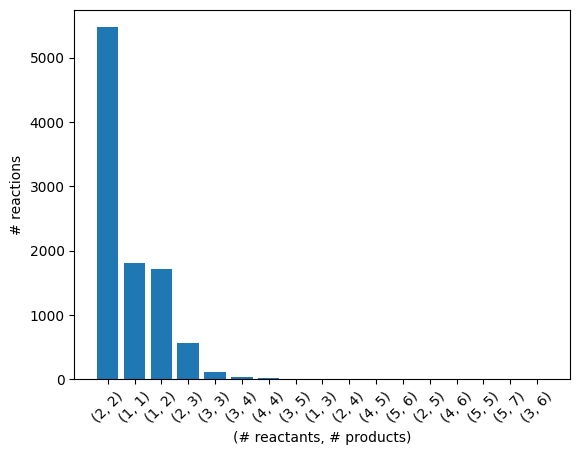

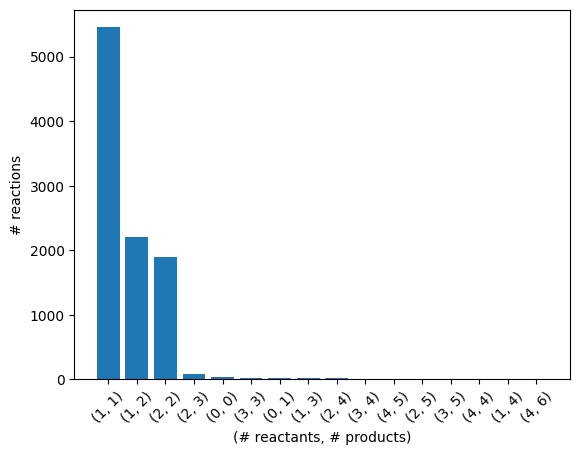

In [14]:
# Filter unpaired cofactors only
filtered_krs = filter_cofactors(known_reactions, cofactors)
side_counts = defaultdict(set)
for rid, (lhs, rhs) in filtered_krs.items():
    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)
base = plot_side_counts(side_counts)

# Filter paired cofactors
manual_select = [
    65,
    67
]
to_select = [i for i in range(k_top_pairs)] + manual_select
paired_cofactors = [(tuple([known_compounds[id]['smiles'] for id in pair]), id2jaccard[pair])
                    for pair in srt_cofactor_pairs if all([rxns_per_cpd[id] > thresh_n_rxns for id in pair])]
paired_cofactors = [paired_cofactors[idx] for idx in to_select]
paired_cofactors = dict(paired_cofactors)

filtered_krs = filter_cofactors(known_reactions, cofactors, paired_cofactors)
side_counts = defaultdict(set)
for rid, (lhs, rhs) in filtered_krs.items():
    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)

new = plot_side_counts(side_counts)

In [15]:
rxn_sim_mats = defaultdict(dict)
id_rsms = defaultdict(dict)
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])

    if not lhs or not rhs:
        continue

    if len(lhs) > len(rhs):
        tmp = lhs
        lhs = rhs
        rhs = tmp

    left_ids, right_ids = np.array([smi2id[smi] for smi in lhs]), np.array([smi2id[smi] for smi in rhs])
    left_names, right_names = [known_compounds[id]['name'] for id in left_ids], [known_compounds[id]['name'] for id in right_ids]


    # Add cpd sim mats
    i, j = np.array(list(zip(*product(left_ids, right_ids))))
    for k, cs in cc_sim_mats.items():
        data = cs[i, j].reshape(len(left_ids), len(right_ids))
        
        df = pd.DataFrame(data=data, columns=right_names, index=left_names)
        rxn_sim_mats[rid][k] = df

        df = pd.DataFrame(data=data, columns=right_ids, index=left_ids)
        id_rsms[rid][k] = df



In [16]:
# Connect substrates reaction-by-reaction

rxn_cxn = {}
for rid, rsm in id_rsms.items():
    tmp = connect_reaction(rsm)
    if tmp:
        rxn_cxn[rid] = tmp

In [17]:
np.argmin(np.array([1, -1, 0, np.NaN]))

3

In [18]:
# Identify frustrated reactions

frustrated = set()
for rid, entry in rxn_cxn.items():

    if is_frustrated(entry['adj_mat']):
        frustrated.add(rid)

print(f"{len(frustrated)} / {len(rxn_cxn)} = {len(frustrated) / len(rxn_cxn) * 100 :.2f}%")

472 / 9781 = 4.83%


In [19]:
# Any reactions with substrates unaccounted for?

mass_loss = set()
for rid, entry in rxn_cxn.items():
    adj = entry['adj_mat'].to_numpy()
    if (adj.sum(axis=0) == 0).any():
        mass_loss.add(rid)
    elif (adj.sum(axis=0) == 0).any():
        mass_loss.add(rid)

print(f"{len(mass_loss)} / {len(rxn_cxn)} = {len(mass_loss) / len(rxn_cxn) * 100 :.2f}%")

0 / 9781 = 0.00%


In [20]:
# Filter paired cofactors
manual_select = [
    65,
    67
]
to_select = [i for i in range(k_top_pairs)] + manual_select
paired_cofactors = [(pair, id2jaccard[pair])
                    for pair in srt_cofactor_pairs if all([rxns_per_cpd[id] > thresh_n_rxns for id in pair])
]
paired_cofactors = [paired_cofactors[idx] for idx in to_select]
paired_cofactors = dict(paired_cofactors)

# Connect substratee reaction by reaction 

rxn_cxn = {}
for rid, rsm in id_rsms.items():
    tmp = connect_reaction(rsm, paired_cofactors)
    if tmp:
        rxn_cxn[rid] = tmp

In [21]:
# Identify frustrated reactions

frustrated = set()
for rid, entry in rxn_cxn.items():

    if is_frustrated(entry['adj_mat']):
        frustrated.add(rid)

print(f"{len(frustrated)} / {len(rxn_cxn)} = {len(frustrated) / len(rxn_cxn) * 100 :.2f}%")

443 / 9717 = 4.56%


Spot check

In [22]:
def display_rxn_info(rid):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        print(k.upper())
        display(rxn_sim_mats[rid][k])

    adj = rxn_cxn[rid]['adj_mat'].copy()
    adj.columns = [known_compounds[elt]['name'] for elt in adj.columns]
    adj.index = [known_compounds[elt]['name'] for elt in adj.index]
    print("FINAL")
    display(adj)

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), known_compounds[smi2id[smi]]['name'])
            for smi in known_reactions[rid]['smi2name'] if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

In [23]:
options = sorted(frustrated)
frustrated_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

interact(display_rxn_info, rid=frustrated_dropdown)

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 40, 42, 110, 155, 182, 184, 187, 192, 213, 2…

<function __main__.display_rxn_info(rid)>

In [24]:
options = sorted([rid for rid in rxn_cxn if rid not in frustrated])
not_frustrated_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

interact(display_rxn_info, rid=not_frustrated_dropdown)

interactive(children=(Dropdown(description='Rxn ID:', options=(0, 1, 3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17,…

<function __main__.display_rxn_info(rid)>

Look at frustration metric by metric

In [25]:
frustrated = defaultdict(set)
for rid, metrics in rxn_sim_mats.items():
    for m, rsm in metrics.items():

        if is_frustrated(rsm):
            frustrated[m].add(rid)

for k,v in frustrated.items():
    print(f"{k}: {len(v)} / {len(rxn_sim_mats)}")

any_frustrated = set(frustrated['mcs']) | set(frustrated['jaccard']) | set(frustrated['tanimoto'])

print(f"Any (not brics) metric frustrated / total rxns: {len(any_frustrated)} / {len(rxn_sim_mats)}")

print(f"{len(set(frustrated['mcs']) ^ set(frustrated['jaccard']))} / {len(set(frustrated['mcs']) | set(frustrated['jaccard']))}")

mcs: 672 / 9781
tanimoto: 998 / 9781
jaccard: 693 / 9781
Any (not brics) metric frustrated / total rxns: 1671 / 9781
1101 / 1233


In [26]:
options = sorted(any_frustrated)
frustrated_metrics_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_frustrated(rid=frustrated_metrics_dropdown):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        print(f"{k.upper()} frustrated: {rid in frustrated[k]}")
        display(rxn_sim_mats[rid][k])

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), name)
            for smi, name in known_reactions[rid]['smi2name'].items() if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 24, 38, 40, 42, 43, 44, 47, 54, 69, 89, 93, …

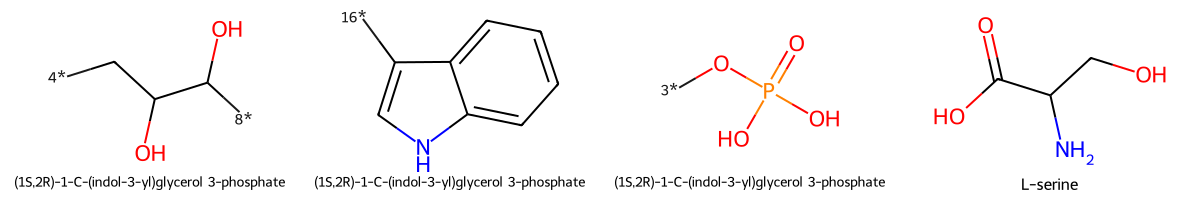

-------------------------------------------------->


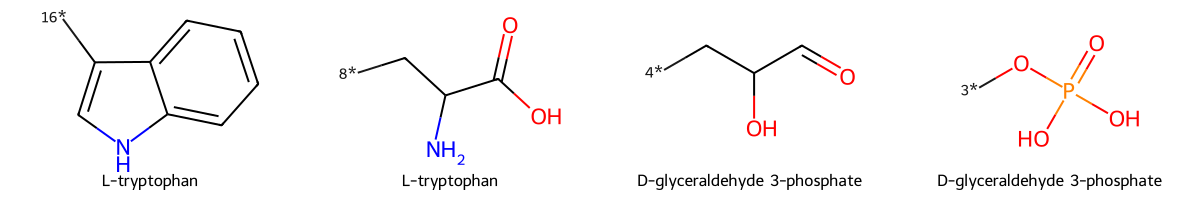

In [27]:
rid = 110
sis = (300, 200)
split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]
for i, side in enumerate(split_subs):
    frags = []
    frag_names = []
    for smi in side:
        if smi in cofactors:
            continue

        name = known_reactions[rid]['smi2name'][smi]
        mol = Chem.MolFromSmiles(smi)
        new_frags = [Chem.MolFromSmiles(elt) for elt in BRICS.BRICSDecompose(mol)]
        frags += new_frags
        frag_names += [name for _ in range(len(new_frags))]
    
    display(Draw.MolsToGridImage(frags, molsPerRow=len(frags), legends=frag_names, subImgSize=sis))

    if i == 0:
        print(f"{'-' * 50}>")

Miscellaneous

In [28]:
# CoA reactions study

coa_rxns = {}
for k, v in known_reactions.items():
    for name in v['smi2name'].values():
        if name is None:
            continue

        if 'CoA' in name:
            coa_rxns[k] = v
            break


unpaired_coa_rxns = {}
for k, v in coa_rxns.items():
    lhs_coa, rhs_coa = False, False
    rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
    lhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None])
    rhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None])

    if lhs_coa ^ rhs_coa:
        unpaired_coa_rxns[k] = v

# for k, v in unpaired_coa_rxns.items():
#     rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
#     rnames = [v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None]
#     pnames = [v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None]
#     print(f"{' + '.join(rnames)} --> {' + '.join(pnames)}")

In [29]:
'''
CoAs always come in pairs unless they are being synthesized
'''

len(coa_rxns), len(unpaired_coa_rxns)

(1533, 27)

{'*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)[nH]c2=O)C1O': 'psi-uridine residue', 'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': 'S-adenosyl-L-methionine', '*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)n(C)c2=O)C1O': "N(3)-methylpseudouridine 5'-phosphate residue", 'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 'S-adenosyl-L-homocysteine'}
0.6666667


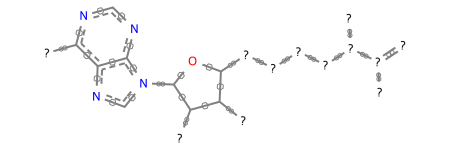

In [30]:
#SAM mcs corner case

print(known_reactions[19]['smi2name'])
smis = [
    'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
    'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O'
]

mols = [Chem.MolFromSmiles(smi) for smi in smis]
print(mcs(mols))

from rdkit.Chem import rdFMCS

res = rdFMCS.FindMCS(
        mols,
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        matchChiralTag=False,
        ringMatchesRingOnly=True,
        completeRingsOnly=False,
        matchValences=False,
        timeout=10
    )
Chem.MolFromSmarts(res.smartsString)

In [18]:
from itertools import product
left_ids = [1,2,3]
right_ids = [5,4,3]

i, j = zip(*product(left_ids, right_ids))
np.random.random(size=(10, 10))[i, j].reshape(len(left_ids), len(right_ids))

array([[0.70401366, 0.49569548, 0.42996604],
       [0.33985828, 0.02541468, 0.4803913 ],
       [0.07735075, 0.58630357, 0.44098932]])

In [16]:
i, j

((1, 1, 1, 2, 2, 2, 3, 3, 3), (5, 4, 3, 5, 4, 3, 5, 4, 3))